# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import zipfile
import sqlite3

# Opening data files, cleaning and assigning to dataframes so team is working from the same dataset

In [2]:
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  


In [3]:
movie_popularity = pd.read_csv("zippedData/tmdb.movies.csv.gz")
print(movie_popularity)

       Unnamed: 0            genre_ids      id original_language  \
0               0      [12, 14, 10751]   12444                en   
1               1  [14, 12, 16, 10751]   10191                en   
2               2        [12, 28, 878]   10138                en   
3               3      [16, 35, 10751]     862                en   
4               4        [28, 878, 12]   27205                en   
...           ...                  ...     ...               ...   
26512       26512             [27, 18]  488143                en   
26513       26513             [18, 53]  485975                en   
26514       26514         [14, 28, 12]  381231                en   
26515       26515      [10751, 12, 28]  366854                en   
26516       26516             [53, 27]  309885                en   

                                     original_title  popularity release_date  \
0      Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      

In [4]:
#cleaning 
movie_gross_data = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross_data["foreign_gross"].fillna(0, inplace = True)
movie_gross_data["domestic_gross"].fillna(0, inplace = True)
movie_gross_data.dropna(inplace = True)
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year  


In [5]:
#cleaning 
movie_gross_data["domestic_gross"].replace(',','', regex = True, inplace = True)
movie_gross_data["foreign_gross"].replace(',','', regex = True, inplace = True)

In [6]:
movie_gross_data["total_gross"] = movie_gross_data["foreign_gross"].astype(float) + movie_gross_data["domestic_gross"].astype(float)
print(movie_gross_data)

                                            title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Actor Prepares       Grav.          1700.0   

     foreign_gross  year   

Using zipfile to unzip imdb database and creating connection to the database

In [7]:
with zipfile.ZipFile("zippedData/im.db.zip", "r") as zObject:
        zObject.extractall()

In [8]:
conn = sqlite3.connect("im.db")
cur = conn.cursor()

Ensuring database is pulling correctly by running simple queries, analyzing columns to see where movie_basics and movie_ratings tables join

In [9]:
pd.read_sql("""
SELECT *
FROM movie_basics
GROUP BY genres
;
""", conn).head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,NaN,None
1,tt0364201,Aman Ke Farishtey,Aman Ke Farishtey,2016,137.0,Action
2,tt6848590,Moonshine Meat Market Mayhem,Moonshine Meat Market Mayhem,2016,NaN,"Action,Adult,Comedy"
3,tt10097958,Gripped: Climbing Killer Pillar,Gripped: Climbing Killer Pillar,2019,NaN,"Action,Adventure"
4,tt0448694,Puss in Boots,Puss in Boots,2011,90.0,"Action,Adventure,Animation"


In [10]:
pd.read_sql("""
SELECT *
FROM movie_ratings
;
""", conn).head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


# Question: What movies are doing well at the box office by genre and ratings? 

Below is the query I ran to find join the movie_ratings and movie_basics tables from the imdb database to pull genres and movie ratings. I wanted to pull genres with a rating of 8.4 or higher and to exclude those rows that have a null value for genre. I wanted the results in descendingorder so I have ratings of 10 at the top. I then made the query into a dataframe so I can graph it and group the genres so I have a more concise and accurate dataset.

In [11]:
q = """
SELECT averagerating as avg_rating, genres
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating >= 8.5
AND genres IS NOT NULL
GROUP BY genres
ORDER BY avg_rating DESC
;
"""
high_ratings = pd.read_sql(q, conn)
print(high_ratings)

     avg_rating                        genres
0           9.8            Comedy,Documentary
1           9.7               Documentary,War
2           9.7    Documentary,Family,Romance
3           9.7      Comedy,Documentary,Sport
4           9.6  Animation,Documentary,Family
..          ...                           ...
285         8.5      Action,Documentary,Sport
286         8.5          Action,Crime,Mystery
287         8.5            Action,Crime,Drama
288         8.5      Action,Adventure,History
289         8.5              Action,Adventure

[290 rows x 2 columns]


Pulling top 30 rows from the dataframe as these are the most relevant to helping support my original question 

In [12]:
top_30 = high_ratings.iloc[:30]

print(top_30)

    avg_rating                         genres
0          9.8             Comedy,Documentary
1          9.7                Documentary,War
2          9.7     Documentary,Family,Romance
3          9.7       Comedy,Documentary,Sport
4          9.6   Animation,Documentary,Family
5          9.5                  Drama,History
6          9.4          Documentary,Drama,War
7          9.4         Crime,Documentary,News
8          9.4     Comedy,Documentary,Fantasy
9          9.4               Adventure,Family
10         9.4             Action,Documentary
11         9.3                        Musical
12         9.3     Documentary,Family,Musical
13         9.3        Documentary,Drama,Music
14         9.3         Crime,Mystery,Thriller
15         9.3  Adventure,Documentary,History
16         9.3   Adventure,Documentary,Family
17         9.3               Action,Drama,War
18         9.3   Action,Biography,Documentary
19         9.2                            War
20         9.2                    

# Visualization to learn more about the data and form recommendation

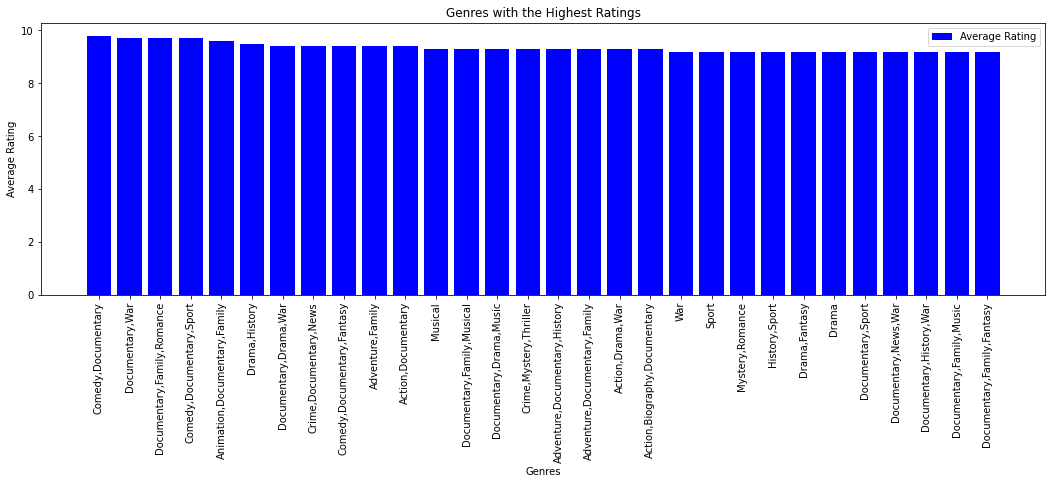

In [13]:
plt.figure(figsize=(18, 5))
plt.bar(top_30["genres"], top_30["avg_rating"], color = "b")
plt.xlabel("Genres")
plt.xticks(rotation = 90)
plt.ylabel("Average Rating")
plt.title("Genres with the Highest Ratings")
plt.legend(labels=['Average Rating'])
plt.show()

# Information about genres with the lowest ratings to help support our recommendation

In [14]:
q2 = """
SELECT averagerating as avg_rating, genres
FROM movie_ratings
JOIN movie_basics
    USING (movie_id)
WHERE averagerating <= 2
AND genres IS NOT NULL
GROUP BY genres
ORDER BY avg_rating DESC
;
"""
low_ratings = pd.read_sql(q2, conn)
print(low_ratings)

     avg_rating                      genres
0           2.0             Sci-Fi,Thriller
1           2.0                     Romance
2           2.0                        News
3           2.0       Drama,Mystery,Romance
4           2.0                       Crime
..          ...                         ...
119         1.0         Comedy,Drama,Horror
120         1.0      Adventure,Drama,Sci-Fi
121         1.0            Adventure,Comedy
122         1.0  Adventure,Biography,Comedy
123         1.0  Adventure,Animation,Family

[124 rows x 2 columns]


In [15]:
top_30_low = low_ratings.iloc[:30]

print(top_30_low)

    avg_rating                   genres
0          2.0          Sci-Fi,Thriller
1          2.0                  Romance
2          2.0                     News
3          2.0    Drama,Mystery,Romance
4          2.0                    Crime
5          2.0           Comedy,Fantasy
6          2.0                   Comedy
7          2.0                Biography
8          2.0                Animation
9          2.0             Adult,Horror
10         2.0   Action,Horror,Thriller
11         2.0  Action,Adventure,Horror
12         1.9                   Sci-Fi
13         1.9         Romance,Thriller
14         1.9   Horror,Sci-Fi,Thriller
15         1.9  Horror,Mystery,Thriller
16         1.9           Fantasy,Horror
17         1.9              Documentary
18         1.9   Comedy,Musical,Romance
19         1.9    Comedy,Fantasy,Horror
20         1.9            Comedy,Family
21         1.9     Comedy,Crime,Romance
22         1.9      Action,Thriller,War
23         1.9   Action,Sci-Fi,Thriller


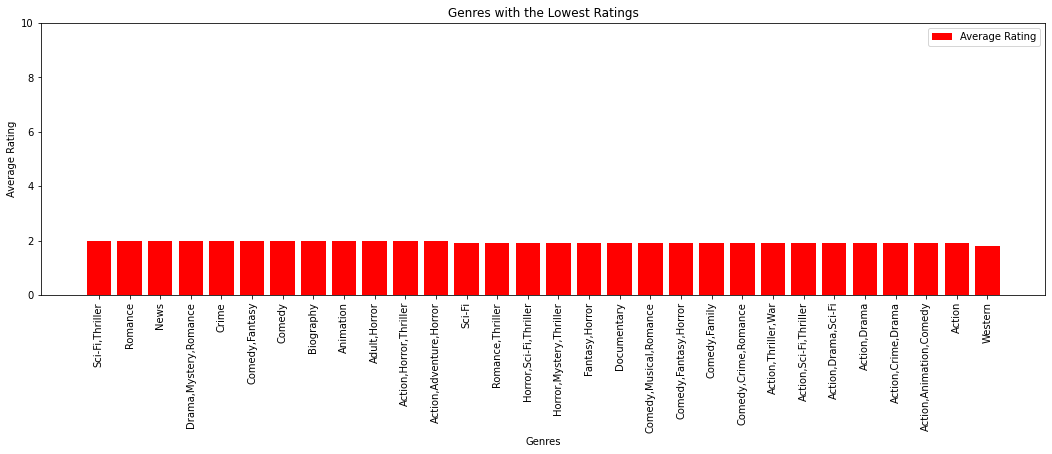

In [24]:
plt.figure(figsize=(18, 5))

plt.bar(top_30_low["genres"], top_30_low["avg_rating"], color = "r")
plt.xlabel("Genres")
plt.xticks(rotation = 90)
plt.ylabel("Average Rating")
plt.yticks(range(0,11,2))
plt.title("Genres with the Lowest Ratings")
plt.legend(labels=['Average Rating'])
plt.show()